# Advanced Econometrics (JEM217) – Empirical Project (WS 2025)

- **Title:      Determinants of Lap Times in Formula 1**
- **Authors:    Sebastian Pasz \& Vojtěch Dohnal**

**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.

In [81]:
req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2","gmm","msm","plm","modelsummary","readxl","lubridate","stringr","corrplot","Amelia","visdat","gridExtra")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)
library(gmm)
library(msm)
library(plm)
library(modelsummary)
library(readxl)
library(lubridate)
library(stringr)
library(corrplot)
library(Amelia)
library(visdat)
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 4.4.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [47]:
data <- read_excel("./Dataset_2025.xlsx")

print(sum(!complete.cases(data[, c("Driver", "LapTime", "LapNumber", "Compound", "TyreLife", 
                             "Team", "TrackStatus", "Position", "AirTemp", 
                             "Humidity", "Pressure", "Rainfall", "TrackTemp", "WindSpeed")])))

str(data)

[1] 927
tibble [29,145 × 41] (S3: tbl_df/tbl/data.frame)
 $ year              : num [1:29145] 2025 2025 2025 2025 2025 ...
 $ country           : chr [1:29145] "Abu Dhabi" "Abu Dhabi" "Abu Dhabi" "Abu Dhabi" ...
 $ session           : chr [1:29145] "Race" "Race" "Race" "Race" ...
 $ Time              : num [1:29145] 0.0416 0.0416 0.0416 0.0416 0.0416 ...
 $ Driver            : chr [1:29145] "VER" "PIA" "NOR" "LEC" ...
 $ DriverNumber      : chr [1:29145] "1" "81" "4" "16" ...
 $ LapTime           : num [1:29145] 0.00106 0.00108 0.00109 0.0011 0.0011 ...
 $ LapNumber         : num [1:29145] 1 1 1 1 1 1 1 1 1 1 ...
 $ Stint             : num [1:29145] 1 1 1 1 1 1 1 1 1 1 ...
 $ PitOutTime        : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ PitInTime         : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ Sector1Time       : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ Sector2Time       : num [1:29145] 0.000445 0.000444 0.000448 0.00045 0.000447 ...
 $ Sector3Time      

In [48]:

# Count how many races is in the dataset
num_unique_races <- data %>%
  distinct(year, country) %>%
  nrow()

print(num_unique_races)

data <- data[, colSums(!is.na(data)) > 0]


[1] 24


In [49]:
# Clean and convert TrackStatus
data <- data %>%
  mutate(TrackStatus = as.character(TrackStatus))

# Create dummy variables
for (status_code in 1:7) {
  varname <- paste0("TrackStatus_", status_code)
  data[[varname]] <- ifelse(str_detect(data$TrackStatus, as.character(status_code)), 1, 0)
}

data <- data %>% select(-TrackStatus_1, -TrackStatus_3, -TrackStatus_7)

data <- data %>%
  mutate(Rainfall = ifelse(Rainfall == TRUE, 1, 0))
# Convert LapTime and sector times to numeric seconds
data <- data %>%
  mutate(
    Time = Time * 86400,
    LapTime = LapTime * 86400,
    PitOutTime = PitOutTime * 86400,
    PitInTime = PitInTime * 86400,
    Sector1Time = Sector1Time * 86400,
    Sector2Time = Sector2Time * 86400,
    Sector3Time = Sector3Time * 86400,
    LapStartTime = LapStartTime * 86400
  )


data <- data %>%
  mutate(
    PitInTime = as.numeric(PitInTime),
    PitOutTime = as.numeric(PitOutTime)
  )

# Replace NA with 0 safely
data <- data %>%
  mutate(
    PitInTime = ifelse(is.na(PitInTime), 0, PitInTime),
    PitOutTime = ifelse(is.na(PitOutTime), 0, PitOutTime),
    InPit = ifelse(!is.na(PitInTime) & PitInTime > 0, 1, 0),
    OutPit = ifelse(!is.na(PitOutTime) & PitOutTime > 0, 1, 0)
  )

In [ ]:
#Lag creation - based of Litrev
data <- data %>%
  mutate(LapNumber = as.numeric(LapNumber)) %>%
  mutate(RaceID = paste0(country, year, session)) %>%
  arrange(Driver, RaceID, LapNumber) %>%
  group_by(Driver, RaceID) %>%
  mutate(
    row_id = row_number(),  # helper index
    TrackStatus_2_lag1 = TrackStatus_2[match(row_id - 1, row_id)],
    TrackStatus_2_lag2 = TrackStatus_2[match(row_id - 2, row_id)],
    
    TrackStatus_4_lag1 = TrackStatus_4[match(row_id - 1, row_id)],
    TrackStatus_4_lag2 = TrackStatus_4[match(row_id - 2, row_id)],
    
    TrackStatus_5_lag1 = TrackStatus_5[match(row_id - 1, row_id)],
    TrackStatus_5_lag2 = TrackStatus_5[match(row_id - 2, row_id)],
    TrackStatus_5_lag3 = TrackStatus_5[match(row_id - 3, row_id)],
    
    TrackStatus_6_lag1 = TrackStatus_6[match(row_id - 1, row_id)],
    TrackStatus_6_lag2 = TrackStatus_6[match(row_id - 2, row_id)],
    
    OutPit_lag1 = OutPit[match(row_id - 1, row_id)]
  ) %>%
  select(-row_id) %>%
  ungroup()

cols_to_fill <- c(
  "TrackStatus_2_lag1","TrackStatus_2_lag2","TrackStatus_4_lag1","TrackStatus_4_lag2",
  "TrackStatus_5_lag1","TrackStatus_5_lag2","TrackStatus_5_lag3",
  "TrackStatus_6_lag1","TrackStatus_6_lag2","OutPit_lag1"
)

data <- data %>%
  mutate(across(all_of(cols_to_fill), ~ ifelse(is.na(.), 0, .)))

unique(data$Compound)
data <- data %>%
  filter(!(Compound %in% c("UNKNOWN", "nan"))) %>%
  mutate(Compound = droplevels(as.factor(Compound)))
unique(data$Compound)

[1] "SOFT"         "HARD"         "MEDIUM"       "INTERMEDIATE" "nan"

[1] SOFT         HARD         MEDIUM       INTERMEDIATE
Levels: HARD INTERMEDIATE MEDIUM SOFT

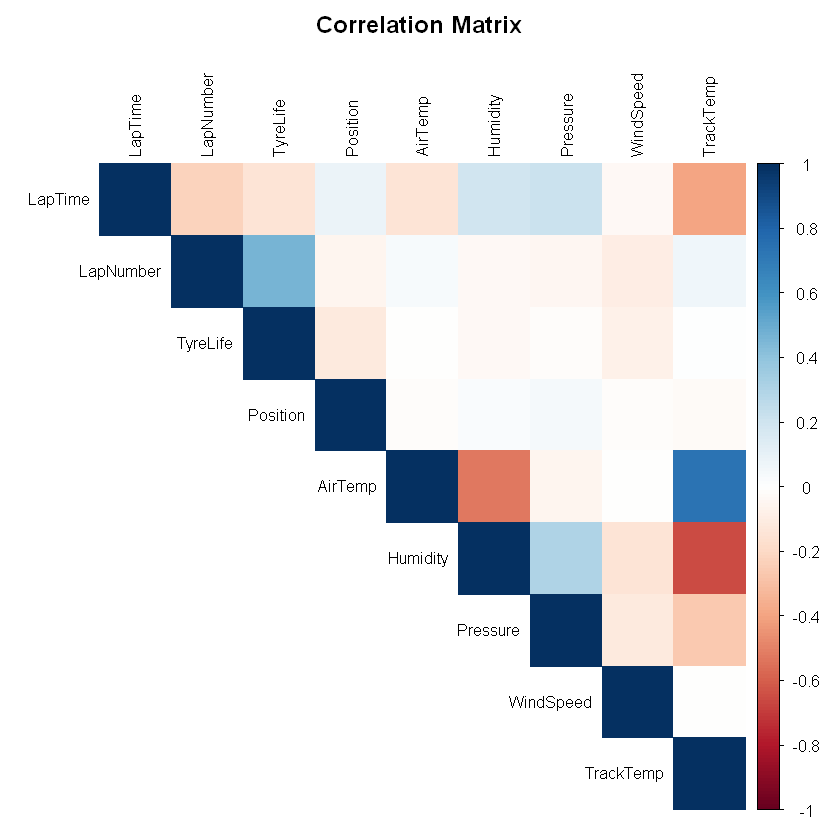

In [51]:
# variance covariance matrix
vars <- c("LapTime", "LapNumber", "TyreLife", "Position", 
          "AirTemp", "Humidity", "Pressure", "WindSpeed", "TrackTemp")

# Remove rows with NAs
data <- data[complete.cases(data[ , vars]), ]
# Compute covariance matrix
cov_matrix <- cov(data[ , vars])

cor_matrix <- cov2cor(cov_matrix)
par(bg = "white")
#  plot data#  plot 
corrplot(cor_matrix, method = "color", type = "upper", 
         tl.col = "black", tl.cex = 0.8, title = "Correlation Matrix", 
         mar = c(0,0,2,0))



In [53]:
colnames(data)

[1] "year"               "country"            "session"           
 [4] "Time"               "Driver"             "DriverNumber"      
 [7] "LapTime"            "LapNumber"          "Stint"             
[10] "PitOutTime"         "PitInTime"          "Sector1Time"       
[13] "Sector2Time"        "Sector3Time"        "Sector1SessionTime"
[16] "Sector2SessionTime" "Sector3SessionTime" "SpeedI1"           
[19] "SpeedI2"            "SpeedFL"            "SpeedST"           
[22] "IsPersonalBest"     "Compound"           "TyreLife"          
[25] "FreshTyre"          "Team"               "LapStartTime"      
[28] "TrackStatus"        "Position"           "FastF1Generated"   
[31] "IsAccurate"         "AirTemp"            "Humidity"          
[34] "Pressure"           "Rainfall"           "TrackTemp"         
[37] "WindDirection"      "WindSpeed"          "TrackStatus_2"     
[40] "TrackStatus_4"      "TrackStatus_5"      "TrackStatus_6"     
[43] "InPit"              "OutPit"             "RaceID"            
[46] "TrackStatus_2_lag1" "TrackStatus_2_lag2" "TrackStatus_4_lag1"
[49] "TrackStatus_4_lag2" "TrackStatus_5_lag1" "TrackStatus_5_lag2"
[52] "TrackStatus_5_lag3" "TrackStatus_6_lag1" "TrackStatus_6_lag2"
[55] "OutPit_lag1"

In [54]:
head(data)
data <- data %>%
  select(-Time, -DriverNumber,
         -Sector1SessionTime, -Sector2SessionTime, -Sector3SessionTime,
         -SpeedFL, -LapStartTime,
         -TrackStatus, -Sector1Time, -Sector2Time, -Sector3Time,
         -PitOutTime, -PitInTime,
         -IsPersonalBest, -FastF1Generated, -IsAccurate,
         -WindDirection, -year, -SpeedI1, -SpeedI2, -SpeedST, -FreshTyre, -WindSpeed)
colnames(data)

year,country,session,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,⋯,TrackStatus_2_lag1,TrackStatus_2_lag2,TrackStatus_4_lag1,TrackStatus_4_lag2,TrackStatus_5_lag1,TrackStatus_5_lag2,TrackStatus_5_lag3,TrackStatus_6_lag1,TrackStatus_6_lag2,OutPit_lag1
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025,Abu Dhabi,Race,3600.491,ALB,23,99.757,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3692.201,ALB,23,91.710,2,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3782.425,ALB,23,90.224,3,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3873.299,ALB,23,90.874,4,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3963.613,ALB,23,90.314,5,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,4053.836,ALB,23,90.223,6,1,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] "country"            "session"            "Driver"            
 [4] "LapTime"            "LapNumber"          "Stint"             
 [7] "Compound"           "TyreLife"           "Team"              
[10] "Position"           "AirTemp"            "Humidity"          
[13] "Pressure"           "Rainfall"           "TrackTemp"         
[16] "TrackStatus_2"      "TrackStatus_4"      "TrackStatus_5"     
[19] "TrackStatus_6"      "InPit"              "OutPit"            
[22] "RaceID"             "TrackStatus_2_lag1" "TrackStatus_2_lag2"
[25] "TrackStatus_4_lag1" "TrackStatus_4_lag2" "TrackStatus_5_lag1"
[28] "TrackStatus_5_lag2" "TrackStatus_5_lag3" "TrackStatus_6_lag1"
[31] "TrackStatus_6_lag2" "OutPit_lag1"

Warning message:
"Unknown or uninitialised column: `arguments`."
Warning message:
"Unknown or uninitialised column: `arguments`."
Warning message:
"Unknown or uninitialised column: `imputations`."


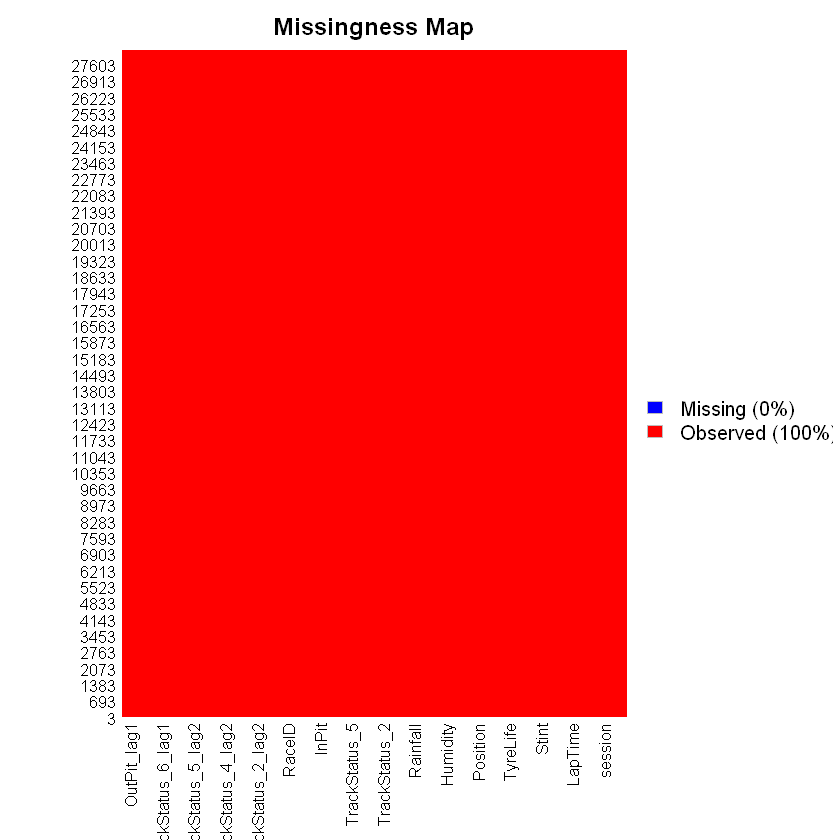

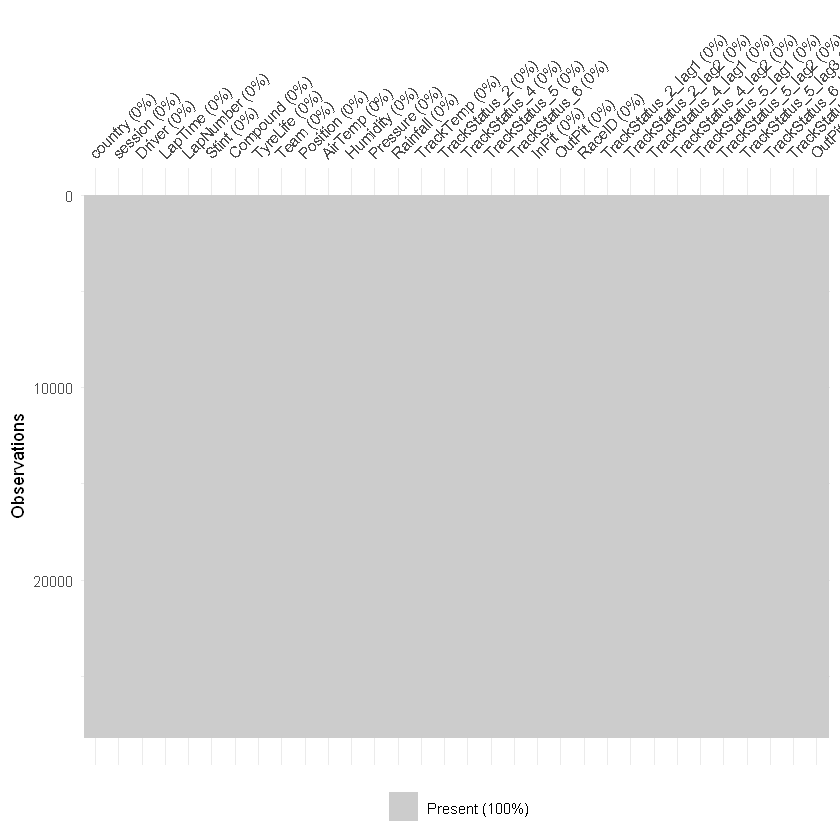

In [55]:
par(bg = "white")
missmap(data, col = c("blue", "red"))

vis_miss(data, warn_large_data = F)

In [65]:
# Dealing with outliers
grouped_outliers <- data %>%
  group_by(Driver, country, session) %>%  # Change if other grouping is needed
  mutate(
    Q1 = quantile(LapTime, 0.25, na.rm = TRUE),
    Q3 = quantile(LapTime, 0.75, na.rm = TRUE),
    IQR = Q3 - Q1,
    lower_bound = Q1 - 1.5 * IQR,
    upper_bound = Q3 + 1.5 * IQR,
    is_outlier = LapTime < lower_bound | LapTime > upper_bound
  )


Q1 = quantile(data$LapTime, 0.25, na.rm = TRUE)
Q3 = quantile(data$LapTime, 0.75, na.rm = TRUE)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count total number of outliers
outlier_count <- sum(grouped_outliers$is_outlier, na.rm = TRUE)
cat("Total number of outliers in LapTime:", outlier_count, "\n")

Total number of outliers in LapTime: 2969 


In [ ]:
# Filter Outliers
data <- data %>%
  group_by(Driver,country, session) %>%
  filter(!is.na(LapTime)) %>%
  mutate(
    Q1 = quantile(LapTime, 0.25, na.rm = TRUE),
    Q3 = quantile(LapTime, 0.75, na.rm = TRUE),
    IQR = Q3 - Q1,
    lower_bound = Q1 - 1.5 * IQR,
    upper_bound = Q3 + 1.5 * IQR
  ) %>%
  filter(
    (LapTime >= lower_bound & LapTime <= upper_bound & TrackStatus_2 == 0 & TrackStatus_4 == 0 & TrackStatus_5 == 0 & TrackStatus_6 == 0)
  ) %>%
  select(-Q1, -Q3, -IQR, -lower_bound, -upper_bound)

data <- data %>%
  arrange(Driver, country, session, LapNumber) %>%
  group_by(Driver, country, session)

nrow(data)

Warning message in split.default(plots, rep(1:length(grid_layout), times = grid_layout)):
"data length is not a multiple of split variable"


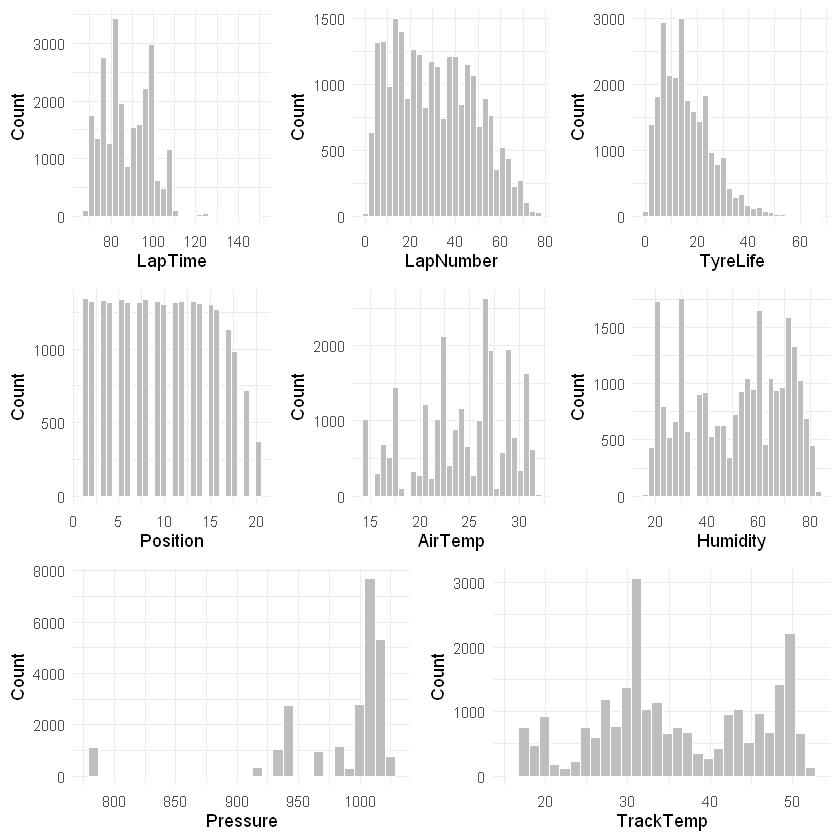

In [79]:
numeric_cols <- c(
  "LapTime", "LapNumber", "TyreLife", "Position", "AirTemp", "Humidity", "Pressure",
  "TrackTemp"
)

# Create list of ggplot histogram objects
plots <- lapply(numeric_cols, function(col_name) {
  ggplot(data, aes_string(x = col_name)) +
    geom_histogram(bins = 30, fill = "grey", color = "white") +
    theme_minimal() +
    labs( x = col_name, y = "Count")
})

# Arrange the plots into a grid (3 per row, last row has 2)
grid_layout <- c(rep(3, 3))  # Defines how many per row

# Split into groups of up to 3
split_plots <- split(plots, rep(1:length(grid_layout), times = grid_layout))

# Draw all rows sequentially
grid_rows <- lapply(split_plots, function(row_plots) {
  do.call(gridExtra::arrangeGrob, c(row_plots, nrow = 1))
})

# Combine all rows into one page and plot
final_plot <- do.call(gridExtra::grid.arrange, c(grid_rows, ncol = 1))

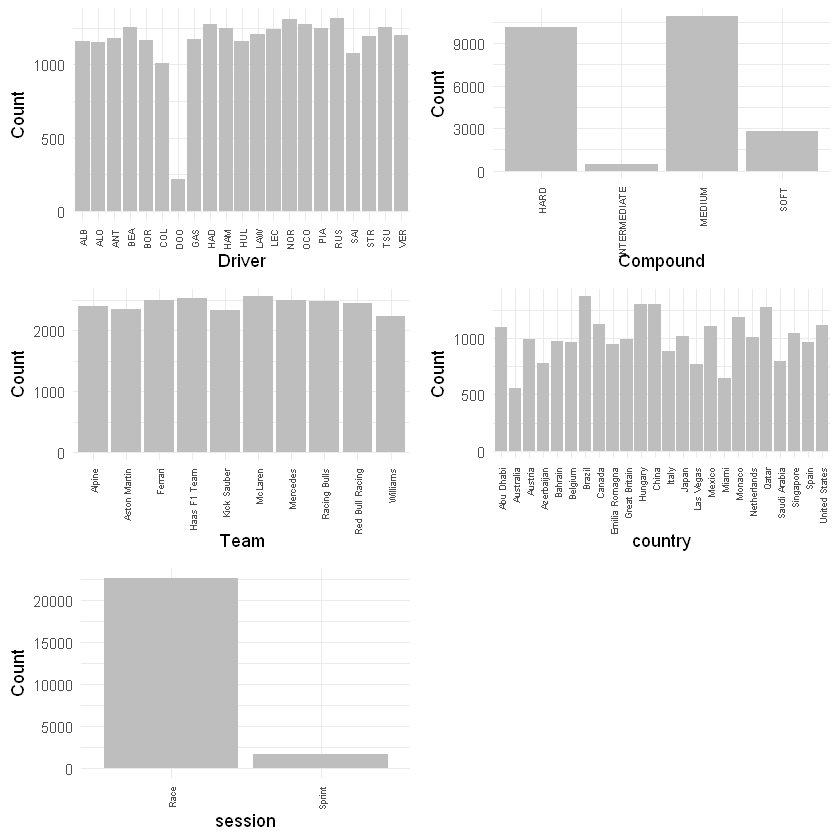

In [84]:
# Define factor variables to plot
factor_vars <- c("Driver", "Compound", "Team", "country", "session")

# Create individual plots for each factor variable
plots <- lapply(factor_vars, function(var) {
  ggplot(data, aes_string(x = var)) +
    geom_bar(fill = "grey") +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 5.3)
    ) +
    labs( x = var, y = "Count")
})
# Arrange plots in a 3x2 grid
grid.arrange(grobs = plots, ncol = 2, nrow = 3)


In [93]:
data <- data %>%
  mutate(
    Compound = as.factor(Compound),
    SessionType = as.factor(session),
    Country = as.factor(country),
    Driver = as.factor(Driver),
    Team = as.factor(Team)
  )


data$RaceID <- paste(data$country, data$session, sep = "_")
data <- data %>%
  mutate(
    LapNumber = as.integer(LapNumber),
    RaceID = as.factor(RaceID),
    Driver = as.factor(Driver)
  )
data <- data %>%
  arrange(Driver, country, session, LapNumber) %>%
  group_by(Driver, country, session)

  cols <- c("LapTime","TyreLife","AirTemp","TrackTemp","Humidity","Pressure","Rainfall", 
           "InPit", "OutPit")
options(scipen = 999)
# Create a summary data frame
summary_stats <- data.frame(
  Variable = cols,
  Mean = sapply(data[cols], mean, na.rm = TRUE ),
  Median = sapply(data[cols], median, na.rm = TRUE ),
  SD = sapply(data[cols], sd, na.rm = TRUE) 
)

# Print the summary
print(summary_stats)


           Variable          Mean   Median          SD
LapTime     LapTime  87.356587949   85.267 10.88896511
TyreLife   TyreLife  15.811004489   14.000  9.67871801
AirTemp     AirTemp  24.207199045   24.800  4.69074416
TrackTemp TrackTemp  35.745051687   33.900  9.77131335
Humidity   Humidity  51.043696718   55.000 18.96750086
Pressure   Pressure 984.495692105 1007.200 52.95088472
Rainfall   Rainfall   0.008278078    0.000  0.09060844
InPit         InPit   0.007536757    0.000  0.08648851
OutPit       OutPit   0.002882913    0.000  0.05361641


In [ ]:
######### 2. Panel Data Structure
data$TimeID <- paste(data$RaceID, data$LapNumber, sep = "_")
pdata <- pdata.frame(data, index = c("Driver", "TimeID"))

data_without_outliers$TimeID <- paste(data_without_outliers$RaceID, data_without_outliers$LapNumber, sep = "_")
pdata2 <- pdata.frame(data_without_outliers, index = c("Driver", "TimeID"))

panel_formula <- LapTime ~
  Position    + WindSpeed+
  TyreLife:Compound + I(TyreLife^2):Compound +
  TrackStatus_2 + TrackStatus_4 + TrackStatus_5 + TrackStatus_6 +
  TrackStatus_2_lag1 + TrackStatus_2_lag2 + TrackStatus_4_lag1 +
  TrackStatus_4_lag2 + TrackStatus_5_lag1 + TrackStatus_5_lag2 + TrackStatus_5_lag3 +
  TrackStatus_6_lag1 + TrackStatus_6_lag2 + OutPit_lag1 +
  OutPit  + InPit+ Rainfall + as.factor(Year) + as.factor(Country) +
  as.factor(SessionType) + as.factor(Team)

# Pooled OLS

pols <- plm(panel_formula, data = pdata, model = "pooling")
pols_restricted <- plm(panel_formula, data = pdata2, model = "pooling")

summary(pols)
summary(pols_restricted)

pols_hac <- coeftest(pols, vcov = vcovHC(pols, type = "HC1", cluster = 'group'))
pols_restricted_hac <- coeftest(pols_restricted, vcov = vcovHC(pols_restricted, type = "HC1", cluster = 'group'))

#QR

quantile_regression <- rq(panel_formula, data = pdata, tau = seq(0.05, 0.95, by = 0.05))
sum_quant_reg <- summary(quantile_regression)
#print(quantile_regression) # see the coefficients, for more details have a look at sum_quant_reg
options(repr.plot.width=18, repr.plot.height=10)
plot(sum_quant_reg, mfrow = c(2, 3))



 # FE
fe_model <- plm(panel_formula, data = pdata, model = "within")
fe_model_restricted <- plm(panel_formula, data = pdata2, model = "within")


summary(fe_model)
summary(fe_model_restricted)


# Breusch-Pagan for FE
bptest(fe_model)
bptest(fe_model_restricted)

# For serial correlation (Wooldridge test)
pbgtest(fe_model)
pbgtest(fe_model_restricted)

#Estimates with Driscoll-Kraays SEe
coefs1 <- coeftest(fe_model, vcov = vcovSCC(fe_model, type = "HC1", maxlag = 5))
coefs2 <- coeftest(fe_model_restricted, vcov = vcovSCC(fe_model_restricted, type = "HC1", maxlag = 5))

# Create new data frame with interleaved rows (Estimate, SE, p-value)
variables <- rownames(coefs1)

table_df <- data.frame(
  Estimate1  = round(coefs1[, 1], 3),
  SE1        = round(coefs1[, 2], 3),
  pval1      = round(coefs1[, 4], 3),
  Estimate2  = round(coefs2[, 1], 3),
  SE2        = round(coefs2[, 2], 3),
  pval2      = round(coefs2[, 4], 3)
)

# Create LaTeX table
xtable(table_df,
       align = "lrrrrrr",  # one left and six right-aligned columns
       caption = "Fixed Effects Model Estimates with Driscoll-Kraay SEs and p-values",
       label = "tab:sidebyside",
       include.rownames = FALSE)


# RANDOM EFFECTS
# Model estimation
re_model <- plm(panel_formula, data = pdata, model = "random", random.method = "walhus")
re_model_restricted <- plm(panel_formula, data = pdata2, model = "random", random.method = "walhus")



# Summary of models
summary(re_model)
summary(re_model_restricted)

# Breusch-Pagan test for heteroskedasticity
bptest(re_model)
bptest(re_model_restricted)

# Wooldridge test for serial correlation
pbgtest(re_model)
pbgtest(re_model_restricted)

# Coefficients with Driscoll-Kraay standard errors
coefs_re1 <- coeftest(re_model, vcov = vcovSCC(re_model, type = "HC1", maxlag = 5))
coefs_re2 <- coeftest(re_model_restricted, vcov = vcovSCC(re_model_restricted, type = "HC1", maxlag = 5))

hausman_test <- phtest(fe_model, re_model)
print(hausman_test)

# Create LaTeX table with interleaved estimates and statistics
variables_re <- rownames(coefs_re1)

table_re_df <- data.frame(
  Estimate1  = round(coefs_re1[, 1], 3),
  SE1        = round(coefs_re1[, 2], 3),
  pval1      = round(coefs_re1[, 4], 3),
  Estimate2  = round(coefs_re2[, 1], 3),
  SE2        = round(coefs_re2[, 2], 3),
  pval2      = round(coefs_re2[, 4], 3)
)

# Generate LaTeX table
xtable(table_re_df,
       align = "lrrrrrr",
       caption = "Random Effects Model Estimates with Driscoll-Kraay SEs and p-values",
       label = "tab:re_sidebyside",
       include.rownames = FALSE)


# #various FE models
# panel_formula2 <- LapTime ~
#   Position + Humidity + Pressure +
#   as.factor(Compound) + 
#   TrackStatus_2 + TrackStatus_4 + TrackStatus_5 + TrackStatus_5_lag1 + TrackStatus_5_lag1 + TrackStatus_6 + TrackStatus_6_lag1 + TrackStatus_6_lag2 +
#   OutPit  + InPit+ Rainfall + as.factor(Year) + as.factor(Country) +
#   as.factor(SessionType) + as.factor(Team)
# 
# # FE
# fe_model2 <- plm(panel_formula2, data = pdata, model = "within")
# fe_model_restricted2 <- plm(panel_formula2, data = pdata2, model = "within")
# 
# 
# summary(fe_model2)
# summary(fe_model_restricted2)
# # Breusch-Pagan for FE
# bptest(fe_model2)
# bptest(fe_model_restricted2)
# 
# # For serial correlation (Wooldridge test)
# pbgtest(fe_model2)
# pbgtest(fe_model_restricted2)
# 
# #Estimates with Driscoll-Kraays SEe
# coefs3 <- coeftest(fe_model2, vcov = vcovSCC(fe_model2, type = "HC1", maxlag = 5))
# coefs4 <- coeftest(fe_model_restricted2, vcov = vcovSCC(fe_model_restricted2, type = "HC1", maxlag = 5))
# 
# #  new data frame with interleaved rows (Estimate, SE, p-value)
# variables <- rownames(coefs3)
# 
# table_df <- data.frame(
#   Estimate3  = round(coefs3[, 1], 3),
#   SE3        = round(coefs3[, 2], 3),
#   pval3      = round(coefs3[, 4], 3),
#   Estimate4  = round(coefs4[, 1], 3),
#   SE4        = round(coefs4[, 2], 3),
#   pval4      = round(coefs4[, 4], 3)
# )
# 
# # LaTeX table
# xtable(table_df,
#        align = "lrrrrrr",  # one left and six right-aligned columns
#        caption = "Fixed Effects Model Estimates with Driscoll-Kraay SEs and p-values",
#        label = "tab:sidebyside",
#        include.rownames = FALSE)


ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
Column `Year` is not found.
Column `Country` is not found.
Column `SessionType` is not found.
